### **Importando as bibliotecas e bases de dados**

In [1]:
# Importando as bibliotecas
import sys
import pandas as pd                        
import numpy as np                             
import seaborn as sns                                 
import matplotlib.pyplot as plt   
from wordcloud import WordCloud
               
from sklearn.cluster import KMeans    
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA  
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import joblib


In [2]:
base_original = pd.read_csv("../data/data.csv")

data_sem_id = base_original.drop('id',axis=1).copy()
indices_duplicados = data_sem_id.loc[data_sem_id.duplicated()].index
base_original = base_original.drop(indices_duplicados, axis=0).reset_index(drop=True)

simular_producao = base_original.sample(2000, random_state=0)
indices_apagar = simular_producao.index.values
simular_producao.to_csv("../data/dados_testes.csv")

base_original = base_original.drop(indices_apagar, axis=0)
base_original.head(3)

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
0,0.0594,1921,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878,10,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954
1,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000,7,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936
2,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913,3,0.101,-14.850,1,Gati Bali,5,1921,0.0339,110.339


### **1. Criando treino e teste, modelo, PCA, e normalizações**

#### **Explicações das etapas seguintes:**

- Separando a base em treino e teste, para simular a entrada de dados
- Criando um modelo KMeans de 5 clusters
- Criando um PCA de 1 componente para as colunas: acousticness, energy e loudness, que estão alto correlacionadas. Isso em uma base que tenha muitas features pode ser importante na redução de dimensionalidade.
- Instanciando normalizadores para padronizar a escala das colunas em 0 e 1

In [3]:
xtreino, xteste = train_test_split(base_original, test_size=0.10, random_state=10)

modelo_kmeans = KMeans(n_clusters=5, 
                init='k-means++', 
                n_init=50,
                max_iter=300,
                tol = 1e-4,
                random_state=0
                )

minmax_year = MinMaxScaler(feature_range=(0,1), clip=True)
minmax_tempo = MinMaxScaler(feature_range=(0,1), clip=True)
minmax_loudness = MinMaxScaler(feature_range=(0,1), clip=True)
minmax_pca = MinMaxScaler(feature_range=(0,1), clip=True)

pca1 = PCA(n_components=1)

### **2. Criando o pipeline**

In [4]:
def selecao_colunas_pipeline(base):
    base = base[['year','tempo','acousticness','danceability','energy','instrumentalness','liveness','loudness','speechiness','valence']]
    return base

colunas_pca = ['acousticness','energy','loudness']
colunas_sem_pca = ['year','tempo','danceability','instrumentalness','liveness','speechiness','valence']

col_pca_pipeline = Pipeline(steps=[
    ('scaler_loudness', minmax_loudness),  
    ('pca', pca1),
    ('scaler_pca', minmax_pca),  
])

col_pipeline = Pipeline(steps=[
    ('scaler_year', minmax_year),
    ('scaler_tempo', minmax_tempo),
])

preprocessamento = ColumnTransformer(transformers=[
    ('pca', col_pca_pipeline, colunas_pca),
    ('cols', col_pipeline, colunas_sem_pca)
])

pipeline = Pipeline(steps=[
    ("selecao_colunas", FunctionTransformer(selecao_colunas_pipeline)),
    ('preprocessamento', preprocessamento),
    ('modelo_cluster', modelo_kmeans)
])

In [5]:
pipeline.fit(xtreino)

Pipeline(steps=[('selecao_colunas',
                 FunctionTransformer(func=<function selecao_colunas_pipeline at 0x000001998E0DD8A0>)),
                ('preprocessamento',
                 ColumnTransformer(transformers=[('pca',
                                                  Pipeline(steps=[('scaler_loudness',
                                                                   MinMaxScaler(clip=True)),
                                                                  ('pca',
                                                                   PCA(n_components=1)),
                                                                  ('scaler_pca',
                                                                   MinMaxScaler(clip=True))]),
                                                  ['acousticness', 'energy',
                                                   'loudness']),
                                                 ('cols',
                                                  Pipeline(steps=[('scaler_year',
                                                                   MinMaxScaler(clip=True)),
                                                                  ('scaler_tempo',
                                                                   MinMaxScaler(clip=True))]),
                                                  ['year', 'tempo',
                                                   'danceability',
                                                   'instrumentalness',
                                                   'liveness', 'speechiness',
                                                   'valence'])])),
                ('modelo_cluster',
                 KMeans(n_clusters=5, n_init=50, random_state=0))])

In [6]:
pipeline.predict(xtreino)

array([3, 2, 2, ..., 4, 3, 2])

In [7]:
xtreino['Cluster'] = pipeline.predict(xtreino)
xtreino

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,Cluster
59153,0.568,1940,0.98700,"['Giorgos Papasideris', 'Nikos Karakostas-Klar...",0.537,194960,0.363,0,1Gv8ct6oLZsdojT3W53i6T,0.185000,1,0.2730,-7.824,1,Ekei psila sta mpalkonakia (to ftiasidi),0,1940-01-01,0.0344,80.986,3
132919,0.748,1982,0.00233,['Twisted Sister'],0.494,232364,0.646,1,2jAwX9kGOxLuaXTaov51oq,0.000000,9,0.6980,-12.125,1,Shoot 'Em Down,32,1982,0.0302,140.311,2
15509,0.738,1999,0.28400,['Dido'],0.722,217827,0.595,0,751gBcu62kORDelX7FV0mM,0.000538,1,0.0694,-9.928,0,Thank You,59,1999-06-01,0.0415,79.980,2
145731,0.913,1972,0.07370,['NRBQ'],0.558,200640,0.753,0,07lRI7dpCGLp1uV8k1Q9J3,0.000576,9,0.1180,-8.309,1,Howard Johnston's Got His Ho-Jo Working,21,1972,0.0374,202.753,2
22262,0.180,1937,0.95700,"['Richard Wagner', 'Otto Wiener', 'Joseph Keil...",0.110,63240,0.108,0,3Ro7C3cPTPmwMd8TcFU8bQ,0.000006,7,0.1680,-23.811,1,3. Aufzug: Die selige Morgentraum-Deutweise,0,1937,0.0396,175.388,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9485,0.145,1969,0.08780,['The Stooges'],0.523,192324,0.941,0,79MMMdYL00iwKVHBSAUkLY,0.148000,4,0.1060,-4.444,0,I Wanna Be Your Dog - 2019 Remaster,59,1969-01-01,0.0377,120.670,1
106839,0.411,2012,0.11400,['Lana Del Rey'],0.582,243173,0.637,0,349XIp8EgHWJiIg5K0CUft,0.000000,11,0.1550,-8.347,0,Dark Paradise,54,2012-01-01,0.0621,119.996,1
94642,0.298,1951,0.99000,['Lata Mangeshkar'],0.524,170893,0.260,0,18kk7ZkCsbtNJU26tP0jfz,0.496000,2,0.1100,-16.254,1,Ujdi Mere Pyar Ki Duniya,0,1951-12-31,0.0382,103.963,4
95843,0.250,1957,0.94000,['Chet Baker'],0.375,191040,0.104,0,1ROntzeztBMrLwY6aMAR61,0.000000,5,0.2580,-16.326,1,Trav'lin' Light,17,1957-08-01,0.0320,73.874,3


In [8]:
xteste['Cluster'] = pipeline.predict(xteste)

In [9]:
xtreino.Cluster.value_counts()

Cluster
2    43062
3    42420
1    36198
4    24680
0     4939
Name: count, dtype: int64

In [10]:
xteste.Cluster.value_counts()

Cluster
3    4826
2    4747
1    3978
4    2699
0     561
Name: count, dtype: int64

### **3. Visualizando as palavras presentes nos nomes das músicas, por Cluster - Base de treino**

In [11]:
cluster_0 = xtreino.loc[xtreino['Cluster'] == 0, "name"].to_list()
cluster_1 = xtreino.loc[xtreino['Cluster'] == 1, "name"].to_list()
cluster_2 = xtreino.loc[xtreino['Cluster'] == 2, "name"].to_list()
cluster_3 = xtreino.loc[xtreino['Cluster'] == 3, "name"].to_list()
cluster_4 = xtreino.loc[xtreino['Cluster'] == 4, "name"].to_list()

nuvem_cluster_0 = ''.join(map(str, cluster_0))
nuvem_cluster_1 = ''.join(map(str, cluster_1))
nuvem_cluster_2 = ''.join(map(str, cluster_2))
nuvem_cluster_3 = ''.join(map(str, cluster_3))
nuvem_cluster_4 = ''.join(map(str, cluster_4))

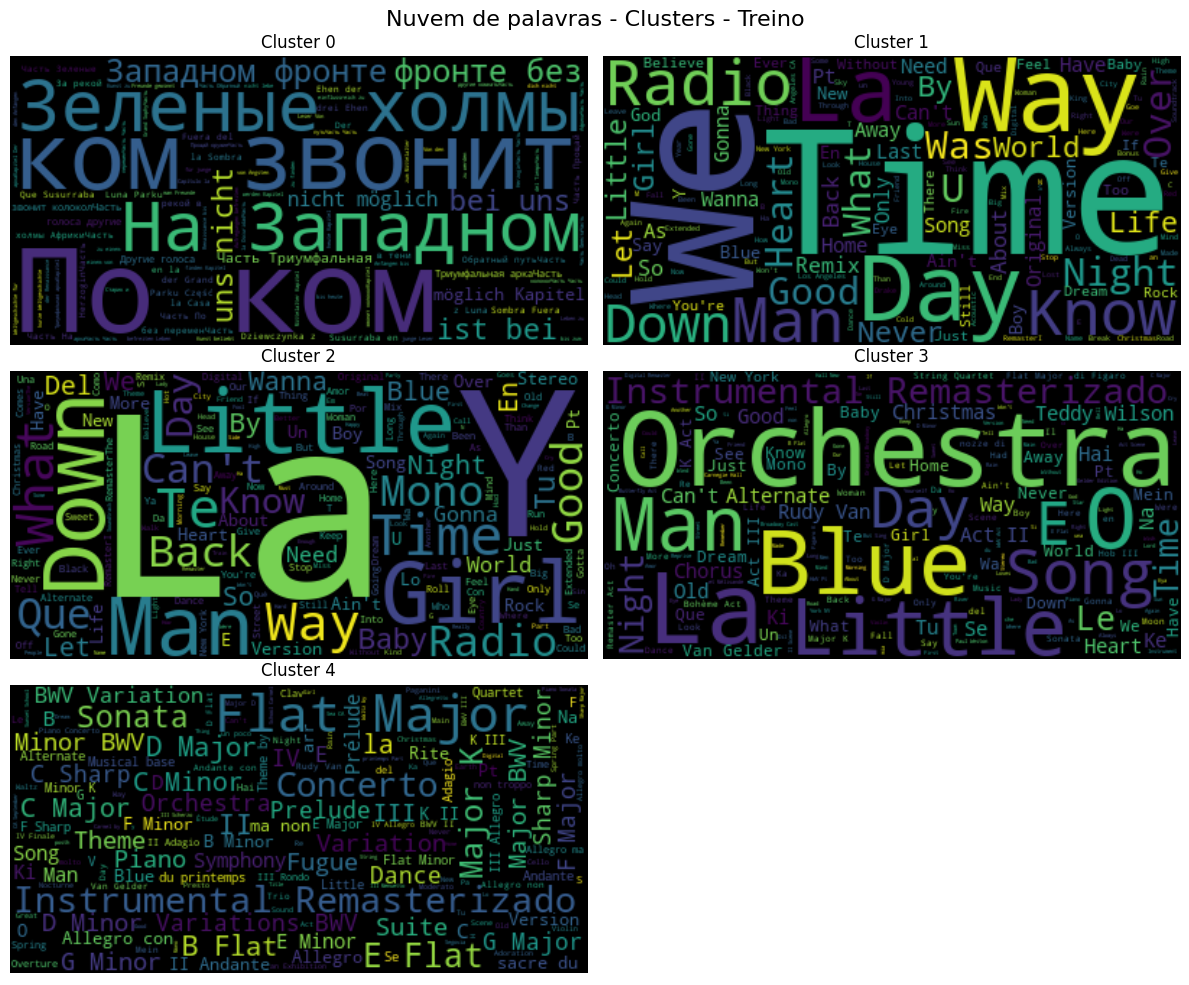

In [12]:
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(12,10), tight_layout=True)

lista_nuvens = [nuvem_cluster_0, nuvem_cluster_1, nuvem_cluster_2, nuvem_cluster_3, nuvem_cluster_4]

titulos = ["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4"]

palavras_ocultar = ['and','or','when','why','the','he','she','it','him','her','they','are','is','am','no','me',
                    'feat','to','a','from','for','at','with','that','feat','in','my','i','op','you','up','de',
                    'all','of','one','on','will','can','be','make','do','out','not','your','go','got','get','mi',
                    "i'm", 'el','live','remastered',"don't",'like','this','come','take','want','his','page','und','die','love','single']

for i, a, t in zip(lista_nuvens, ax.flat, titulos):
    wordcloud = WordCloud(stopwords=palavras_ocultar).generate(i)
    a.imshow(wordcloud, interpolation = 'bilinear')
    a.axis('off')
    a.set_title(t, fontsize=12)
    
plt.suptitle("Nuvem de palavras - Clusters - Treino", fontsize=16)
ax[2][1].axis('off')
plt.show()

### **4. Visualizando as palavras presentes nos nomes das músicas, por Cluster - Base de teste**

In [13]:
cluster_0_teste = xteste.loc[xteste['Cluster'] == 0, "name"].to_list()
cluster_1_teste = xteste.loc[xteste['Cluster'] == 1, "name"].to_list()
cluster_2_teste = xteste.loc[xteste['Cluster'] == 2, "name"].to_list()
cluster_3_teste = xteste.loc[xteste['Cluster'] == 3, "name"].to_list()
cluster_4_teste = xteste.loc[xteste['Cluster'] == 4, "name"].to_list()

nuvem_cluster_0_teste = ''.join(map(str, cluster_0_teste))
nuvem_cluster_1_teste = ''.join(map(str, cluster_1_teste))
nuvem_cluster_2_teste = ''.join(map(str, cluster_2_teste))
nuvem_cluster_3_teste = ''.join(map(str, cluster_3_teste))
nuvem_cluster_4_teste = ''.join(map(str, cluster_4_teste))

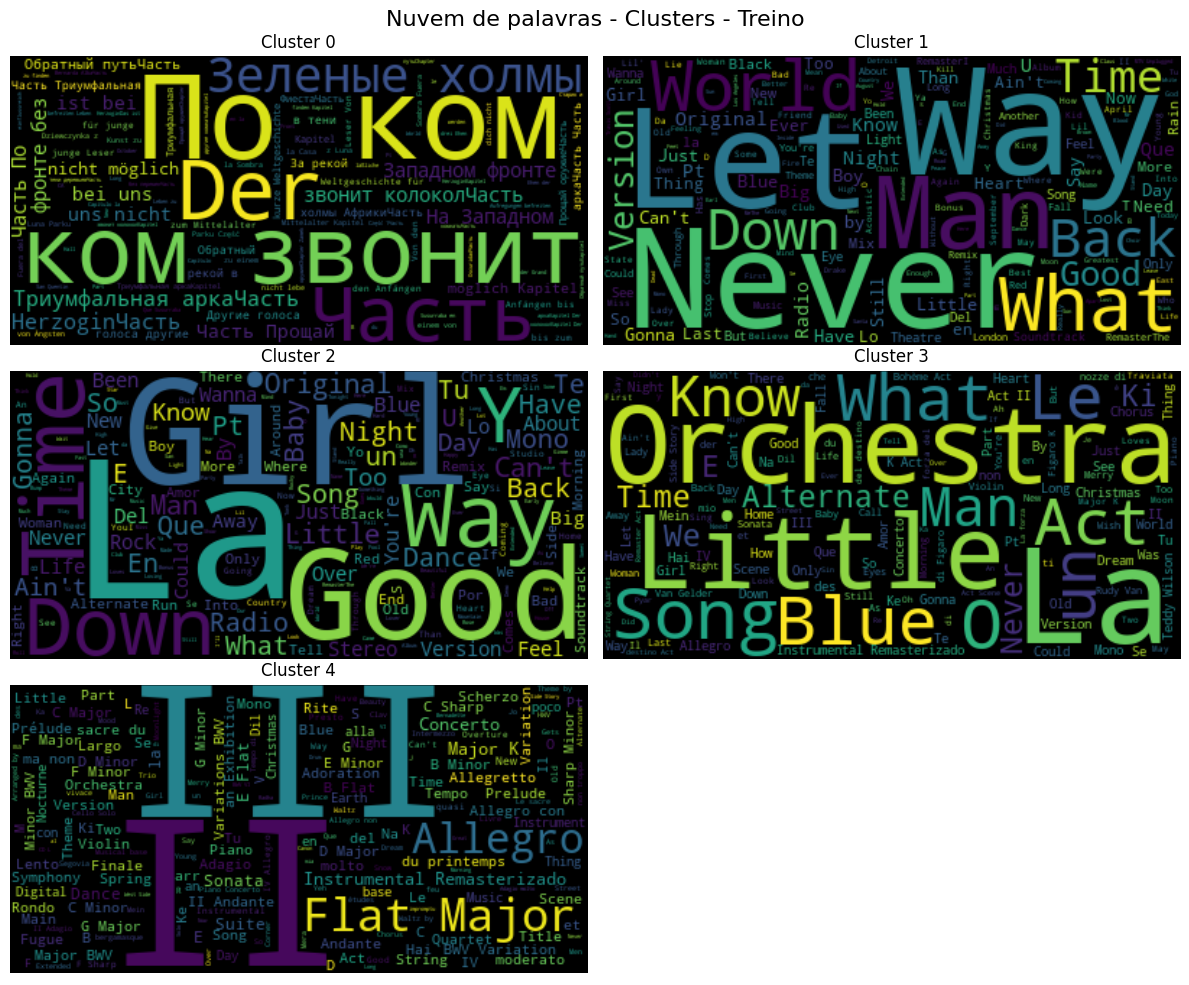

In [14]:
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(12,10), tight_layout=True)

lista_nuvens = [nuvem_cluster_0_teste, nuvem_cluster_1_teste, nuvem_cluster_2_teste, nuvem_cluster_3_teste, nuvem_cluster_4_teste]

titulos = ["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4"]

palavras_ocultar = ['and','or','when','why','the','he','she','it','him','her','they','are','is','am','no','me',
                    'feat','to','a','from','for','at','with','that','feat','in','my','i','op','you','up','de',
                    'all','of','one','on','will','can','be','make','do','out','not','your','go','got','get','mi',
                    "i'm", 'el','live','remastered',"don't",'like','this','come','take','want','his','page','und','die','love','single']

for i, a, t in zip(lista_nuvens, ax.flat, titulos):
    wordcloud = WordCloud(stopwords=palavras_ocultar).generate(i)
    a.imshow(wordcloud, interpolation = 'bilinear')
    a.axis('off')
    a.set_title(t, fontsize=12)
    
plt.suptitle("Nuvem de palavras - Clusters - Treino", fontsize=16)
ax[2][1].axis('off')
plt.show()

### **5. Exportando o pipeline:**

In [15]:
joblib.dump(pipeline, "../models/pipeline.joblib")

['../models/pipeline.joblib']